<a href="https://colab.research.google.com/github/MartoBadi/app_MSIA/blob/main/MDSI_clasificacion_imagenes_Martin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import os
import shutil

In [ ]:
!git clone https://github.com/MartoBadi/app_MSIA.git

# Cambiar el directorio de trabajo a '/content/imagen'
os.chdir('/content/app_MSIA')

# Verificar el directorio de trabajo actual
print("Directorio de trabajo actual:", os.getcwd())

In [ ]:
# Ruta relativa del dataset local
train_dir = './Wonders of World/train'
val_dir = './Wonders of World/val'
test_dir = './Wonders of World/test'

In [ ]:
# Establecer semilla fija para reproducibilidad
seed = 1728676400
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Generadores de datos con ImageDataGenerator
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15  # División de validación
)

datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=seed
)

val_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=seed
)

test_generator = datagen_test.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=seed
)

In [ ]:
# Cargar modelo preentrenado Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [ ]:
# Crear el modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=4,
    verbose=2
)

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 - 715s - 10s/step - accuracy: 0.6876 - loss: 0.9777 - val_accuracy: 0.8229 - val_loss: 0.5360
Epoch 2/4
73/73 - 683s - 9s/step - accuracy: 0.8208 - loss: 0.5331 - val_accuracy: 0.8279 - val_loss: 0.5232
Epoch 3/4
73/73 - 740s - 10s/step - accuracy: 0.8451 - loss: 0.4646 - val_accuracy: 0.8554 - val_loss: 0.4688
Epoch 4/4
73/73 - 669s - 9s/step - accuracy: 0.8568 - loss: 0.4266 - val_accuracy: 0.8678 - val_loss: 0.3894


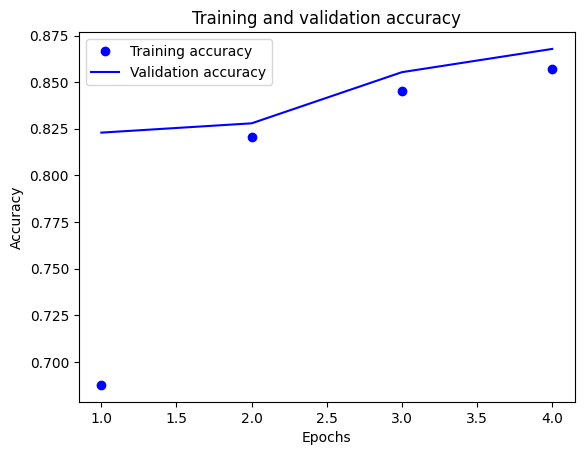

In [ ]:

import matplotlib.pyplot as plt

# Obtener los valores del historial
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Graficar accuracy
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluar el modelo
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print('Test accuracy:', test_acc)

18/18 ━━━━━━━━━━━━━━━━━━━━ 138s 8s/step - accuracy: 0.8941 - loss: 0.3215
Test accuracy: 0.8947368264198303


In [ ]:
# Guardar el modelo en formato .keras
model.save('./modelNella.keras')

In [ ]:
# Convertir el modelo a TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('./modelNella.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpzgjhxvhw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_540')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  134388863975488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134388561015760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134388561012592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134388861095072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134388569974992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134388561366528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134388561368816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134388561378848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134388561376208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134388561377088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134388561

In [ ]:
predicciones = model.predict(test_generator)

print("Las predicciones son: ", predicciones)

18/18 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step
Las predicciones son:  [[2.46610236e-03 1.18886535e-04 9.91401732e-01 ... 1.33057372e-04
  4.18783820e-05 1.42952495e-05]
 [1.23157079e-05 3.64320658e-05 5.04514355e-06 ... 2.67242490e-06
  4.02011119e-06 3.17336657e-07]
 [9.01627995e-04 1.92282926e-02 3.69767589e-03 ... 6.64827676e-05
  3.81903301e-05 4.89553029e-04]
 ...
 [2.96564051e-03 2.20261723e-01 9.95139219e-03 ... 2.16434473e-05
  9.66168102e-03 1.70555197e-07]
 [3.64867287e-06 9.99584019e-01 1.45727518e-06 ... 8.68696134e-07
  6.54694610e-09 2.27982696e-07]
 [1.09651519e-04 4.60366755e-06 1.42674299e-03 ... 1.62795402e-07
  1.22024090e-07 4.01323286e-09]]


In [ ]:

import os
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Ruta a tu carpeta de test
test_dir = './Wonders of World/test'

# Inicializar listas para almacenar etiquetas y las categorías
labels = []
categories = []

# Recorrer cada subdirectorio en la carpeta de test
for category in os.listdir(test_dir):
    category_path = os.path.join(test_dir, category)

    # Comprobar si es un directorio
    if os.path.isdir(category_path):
        categories.append(category)  # Guardar el nombre de la categoría

        # Recorrer cada imagen en el subdirectorio
        for filename in os.listdir(category_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filtrar solo imágenes
                labels.append(category)  # Agregar la etiqueta correspondiente

# Convertir las etiquetas a un array de numpy
Y_test = np.array(labels)

# Si necesitas codificar las etiquetas a números (por ejemplo, usando LabelEncoder)
label_encoder = LabelEncoder()
Y_test_encoded = label_encoder.fit_transform(Y_test)
Y_test_encoded_ord = np.sort(Y_test_encoded)

# Mostrar las primeras etiquetas
print("Etiquetas originales:", Y_test[:10])
print("Etiquetas codificadas:", Y_test_encoded[:10])

Etiquetas originales: ['christ_the_reedemer' 'christ_the_reedemer' 'christ_the_reedemer'
 'christ_the_reedemer' 'christ_the_reedemer' 'christ_the_reedemer'
 'christ_the_reedemer' 'christ_the_reedemer' 'christ_the_reedemer'
 'christ_the_reedemer']
Etiquetas codificadas: [2 2 2 2 2 2 2 2 2 2]


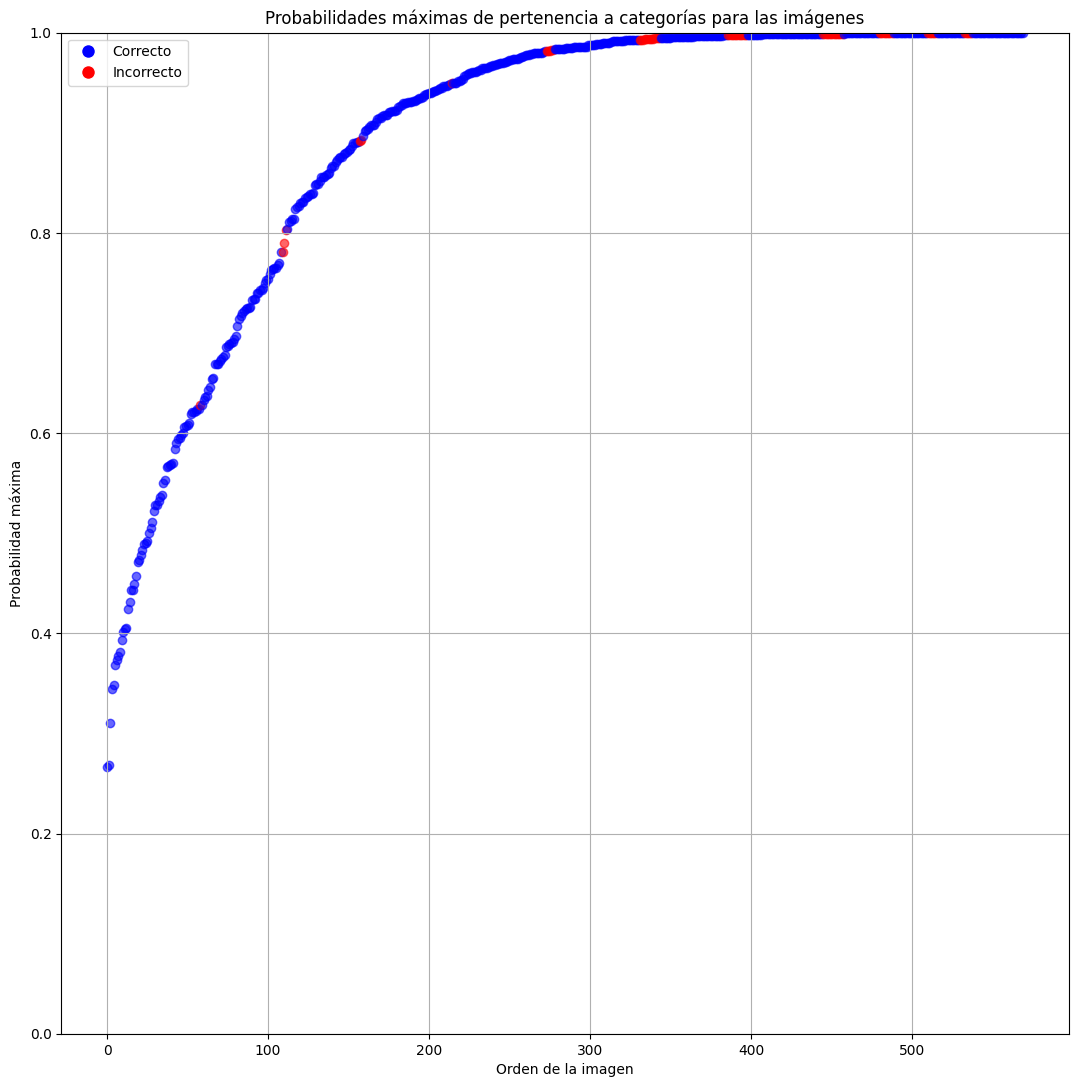

In [ ]:

# Obtener las probabilidades máximas y sus índices
max_probabilities = np.max(predicciones, axis=1)
max_probabilities_ord = np.sort(max_probabilities)
max_indices = np.argmax(predicciones, axis=1)
max_indices_ord = np.sort(max_indices)

# Suponiendo que Y_train son las etiquetas verdaderas (en formato entero)
# Compara las predicciones con las etiquetas reales
correct_predictions = (max_indices_ord == Y_test_encoded_ord)

# Configurar el gráfico
plt.figure(figsize=(13, 13))

# Crear el gráfico de dispersión
for i in range(len(max_probabilities_ord)):
    if correct_predictions[i]:
        plt.scatter(i, max_probabilities_ord[i], color='blue', alpha=0.6)  # Correcto
    else:
        plt.scatter(i, max_probabilities_ord[i], color='red', alpha=0.6)   # Incorrecto

# Configurar el gráfico
plt.xlabel('Orden de la imagen')
plt.ylabel('Probabilidad máxima')
plt.title('Probabilidades máximas de pertenencia a categorías para las imágenes')
plt.ylim(0, 1)  # Ajustar el límite del eje y entre 0 y 1
plt.grid()
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Correcto')
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Incorrecto')
plt.legend(handles=[blue_patch, red_patch], loc='upper left')
plt.show()

Ahora vamos a buscar imágenes de internet que no sean de ninguna maravilla del mundo y probar el modelo con esos datos.

In [11]:
import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO

def buscar_imagenes(query, filtro):
    url = f"https://www.google.com/search?q={query}&tbm=isch"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    imagenes = []

    for img in soup.find_all("img"):
        img_url = img.get("src")
        if img_url and filtro not in img_url:
            imagenes.append(img_url)

    return imagenes

def descargar_imagenes(imagenes, carpeta="imagenes_de_cosas"):
    import os
    if not os.path.exists(carpeta):
        os.makedirs(carpeta)

    for i, img_url in enumerate(imagenes):
        try:
            response = requests.get(img_url)
            img = Image.open(BytesIO(response.content))
            img.save(f"{carpeta}/imagen_{i}.jpg")
        except Exception as e:
            print(f"No se pudo descargar la imagen {img_url}: {e}")

query = "cosa"
filtro = "perros"
imagenes = buscar_imagenes(query, filtro)
descargar_imagenes(imagenes)

No se pudo descargar la imagen /images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif: Invalid URL '/images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif': No scheme supplied. Perhaps you meant https:///images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif?
No se pudo descargar la imagen https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTVcNOudC-m1bw5em1kEOF7RlO-OKMXEaBXyMUXxO2_RpJJOlaVpKfWR3JV2Ok&s: cannot write mode P as JPEG
No se pudo descargar la imagen https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR17IXZbtEZamI6LlDmTYTpElwGHSd_RApNBuR6uH3RykY25l5TdCU-LW3Mv_8&s: cannot write mode P as JPEG
No se pudo descargar la imagen https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTsnbS-7ZNgcozMKkb3QMB557cs1wo9f0Yx2qmzNTXLlNkXESzG7WJtpULA5nk&s: cannot write mode P as JPEG
No se pudo descargar la imagen https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRKcP6M_NIa2LgeDEEKMkrVB2bnxLpEU8-i1A_XKm5Rw9lH2W031Xk-kXFgkw&s

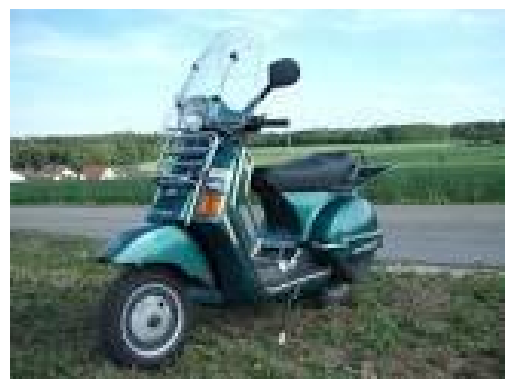

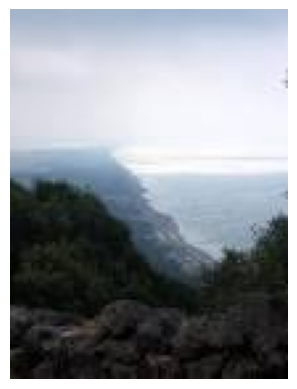

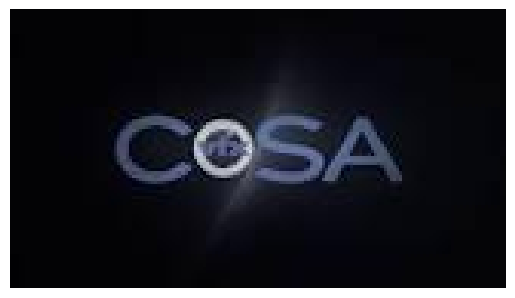

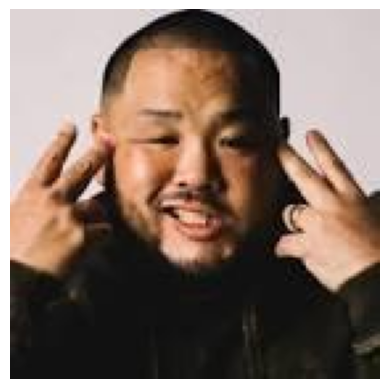

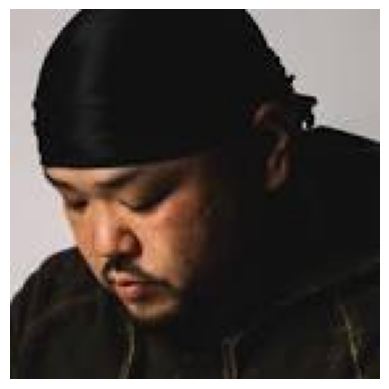

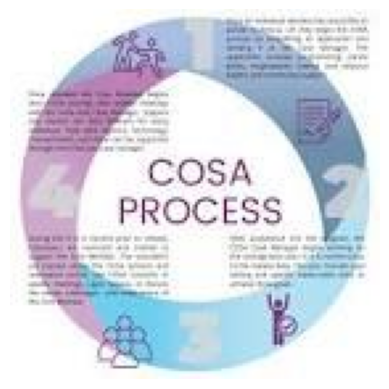

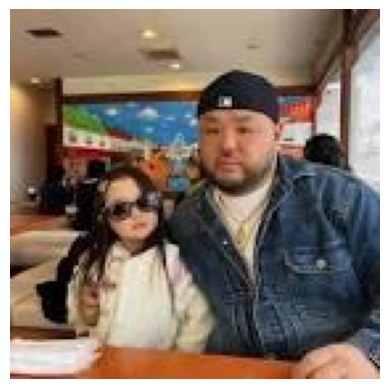

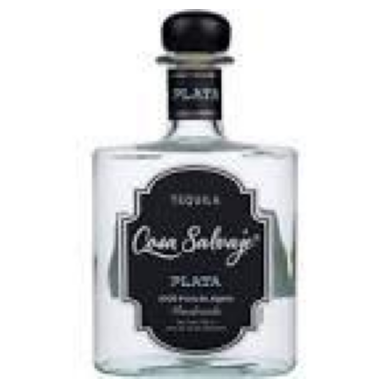

In [13]:
import matplotlib.pyplot as plt
import os

# Directorio donde están guardadas las imágenes
carpeta = "imagenes_de_cosas"

# Listar todas las imágenes en el directorio
imagenes = [img for img in os.listdir(carpeta) if img.endswith(".jpg")]

# Mostrar todas las imágenes
for img_nombre in imagenes:
    img_path = os.path.join(carpeta, img_nombre)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')  # No mostrar los ejes
    plt.show()


In [21]:
!pip install requests beautifulsoup4 pillow

import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
import os

def buscar_imagenes(query, filtros, num_imagenes):
    url = f"https://www.google.com/search?q={query}&tbm=isch"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    imagenes = []

    for img in soup.find_all("img"):
        img_url = img.get("src")
        if img_url and not any(filtro in img_url for filtro in filtros):
            imagenes.append(img_url)
            if len(imagenes) >= num_imagenes:
                break

    return imagenes

def descargar_imagenes(imagenes, carpeta="imagenes"):
    if not os.path.exists(carpeta):
        os.makedirs(carpeta)

    descargadas = 0
    for i, img_url in enumerate(imagenes):
        try:
            response = requests.get(img_url)
            img = Image.open(BytesIO(response.content))
            img.save(f"{carpeta}/imagen_{descargadas}.jpg")
            descargadas += 1
        except Exception as e:
            print(f"No se pudo descargar la imagen {img_url}: {e}")

        if descargadas >= len(imagenes):
            break

# Especifica la cantidad de imágenes que deseas descargar
cantidad_imagenes = 570
query = "cosa"
filtros = ['Burj Khalifa', 'Chichén Itzá', 'Cristo Redentor', 'Torre Eiffel',
               'Gran muralla china', 'Machu Picchu', 'Gran Pirámide de Guiza', 'Coliseo Romano',
               'Estatua de la Libertad', 'Stonehenge', 'Taj Mahal', 'Salto Ángel']
imagenes = buscar_imagenes(query, filtros, cantidad_imagenes)
descargar_imagenes(imagenes)

No se pudo descargar la imagen /images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif: Invalid URL '/images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif': No scheme supplied. Perhaps you meant https:///images/branding/searchlogo/1x/googlelogo_desk_heirloom_color_150x55dp.gif?
No se pudo descargar la imagen https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTVcNOudC-m1bw5em1kEOF7RlO-OKMXEaBXyMUXxO2_RpJJOlaVpKfWR3JV2Ok&s: cannot write mode P as JPEG
No se pudo descargar la imagen https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR17IXZbtEZamI6LlDmTYTpElwGHSd_RApNBuR6uH3RykY25l5TdCU-LW3Mv_8&s: cannot write mode P as JPEG
No se pudo descargar la imagen https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTsnbS-7ZNgcozMKkb3QMB557cs1wo9f0Yx2qmzNTXLlNkXESzG7WJtpULA5nk&s: cannot write mode P as JPEG
No se pudo descargar la imagen https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRKcP6M_NIa2LgeDEEKMkrVB2bnxLpEU8-i1A_XKm5Rw9lH2W031Xk-kXFgkw&s

In [20]:
import shutil

# Ruta de la carpeta que deseas eliminar
carpeta_a_eliminar = '/content/imagenes'

# Eliminar la carpeta y todo su contenido
shutil.rmtree(carpeta_a_eliminar)